In [1]:
#% pip install openpyxl
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import sys
from __globals import *
from _utilities import plot_scatter
sys.path.append("../tools/")
import _db_tools as db
####Helper Functions####
def RyR(dataframe):
    """Calculates and prints the RyR values for both fibers, including a cualitative evaluation"""
    i = 0; df_RyR = [] #Preallocate a counter and an empty dataframe where to add the rows
    std = dataframe.iloc[:, :-2].std(axis=1) #Standard deviation for each row, excluding limits
    for index, _ in enumerate(range(dataframe.shape[0])):
        i+= 1
        RyR = (6*std.iloc[index]/(dataframe.iloc[index,-1]-dataframe.iloc[index,-2]))*100 #Calculates RyR for the whole dataframe
        df_RyR.append(float(RyR)) #Adds the values of RyR to a ndarray
    df_RyR = pd.DataFrame(df_RyR) #Builds a new dataframe with the RyR values
    x_fiber = df_RyR[df_RyR.index % 2 != 0] #Indexes the fiber x RyR values in a new dataframe
    y_fiber = df_RyR[df_RyR.index % 2 == 0] #Indexes the fiber y RyR values in a new dataframe
    dfx = pd.DataFrame(x_fiber).reset_index(drop=True) #Resets row index
    dfy = pd.DataFrame(y_fiber).reset_index(drop=True) #Resets row index
    for i, _ in enumerate(range(dfx.shape[0])): #Prints the dataframe for fiber x row by row indexing with the counter
        Pass = "Correct" if dfx.iloc[i, 0] <= 10 else ("Low fail" if 10 <= dfx.iloc[i, 0] <= 25 else "High fail")
        print(f'RyR Guide fbx {dfx.index[i]+1}: ' + str(dfx.iloc[i, 0]) +' %' + ' Status: ' + Pass)
    print("")
    for i, _ in enumerate(range(dfy.shape[0])): #Prints the dataframe for fiber y row by row
        Pass = "Correct" if dfy.iloc[i, 0] <= 10 else ("Low fail" if 10 <= dfy.iloc[i, 0] <= 25 else "High fail")
        print(f'RyR Guide fby {dfy.index[i]+1}: ' + str(dfy.iloc[i, 0]) +' %' + ' Status: ' + Pass)
    return dfx, dfy

def z_score_filter(dataframe, threshold):
    """Applies a z-score to a Dataframe, filtering values that don't apply."""
    rows = []
    MEAS = dataframe.iloc[:, :-2] #Indexes the measurements
    limits = dataframe.iloc[:, -2:]  #Indexes the limits  
    for row in range(MEAS.shape[0]): #Iterates over the rows
        row = MEAS.iloc[row, :]
        z_scores = (row - row.mean()) / row.std() #Calculates the z-score
        filtered_row = np.where(abs(z_scores) <= threshold, row, np.nan) #Applies the threshold as a filter
        rows.append(filtered_row)
    filtered_df = pd.DataFrame(rows) #Builds a new dataframe
    filtered_df = pd.concat([filtered_df, limits], axis=1) #Adds again the columns
    return filtered_df

In [2]:
#Data preparation
dbh = db.SQLite_Data_Extractor("database.db") #Connect to the database
MEAS = dbh.retrieve(tooling) #Get the desired tooling data
LIMITS = dbh.retrieve(tooling+"_limits") #Get the desired tooling data
dbh.close_conn() 

../database/database.db found.
Table PASSAT_B9 retrieved succesfully.
Table PASSAT_B9_limits retrieved succesfully.
Closed connection to: ../database/database.db


RyR calculation

In [3]:
#Slice the dataframe to obtain only the measures and limits for each fiber
df_plus_limits = pd.concat([MEAS, LIMITS], axis=1) #Gets both the measure and limits
""" df_plus_limits = df_plus_limits.reset_index(drop=True) #Resets the rows index to start in zero again
df_plus_limits.columns = range(df_plus_limits.shape[1]) #Resets the columns index to start in zero again """
#Generate a RyR for each fiber in every scale
RyRx, RyRy = RyR(df_plus_limits)

RyR Guide fbx 1: 8.53283044495216 % Status: Correct
RyR Guide fbx 2: 2.289405885889102 % Status: Correct
RyR Guide fbx 3: 4.079666427653035 % Status: Correct
RyR Guide fbx 4: 2.0126039631890698 % Status: Correct
RyR Guide fbx 5: 1.1292025708167394e-12 % Status: Correct
RyR Guide fbx 6: 4.068381021724936 % Status: Correct
RyR Guide fbx 7: 4.1996168407602354 % Status: Correct
RyR Guide fbx 8: 5.451563099688317 % Status: Correct
RyR Guide fbx 9: 2.4268611769966135 % Status: Correct
RyR Guide fbx 10: 4.78743566326326 % Status: Correct
RyR Guide fbx 11: 1.382983614567378 % Status: Correct
RyR Guide fbx 12: 4.07966642765294 % Status: Correct

RyR Guide fby 1: 12.561572491064895 % Status: Low fail
RyR Guide fby 2: 6.821534529219539 % Status: Correct
RyR Guide fby 3: 9.655205254459688 % Status: Correct
RyR Guide fby 4: 4.5283271885364105 % Status: Correct
RyR Guide fby 5: 2.2584051416334788e-12 % Status: Correct
RyR Guide fby 6: 3.9216463819200484 % Status: Correct
RyR Guide fby 7: 7.708481669

Distribution Fitting

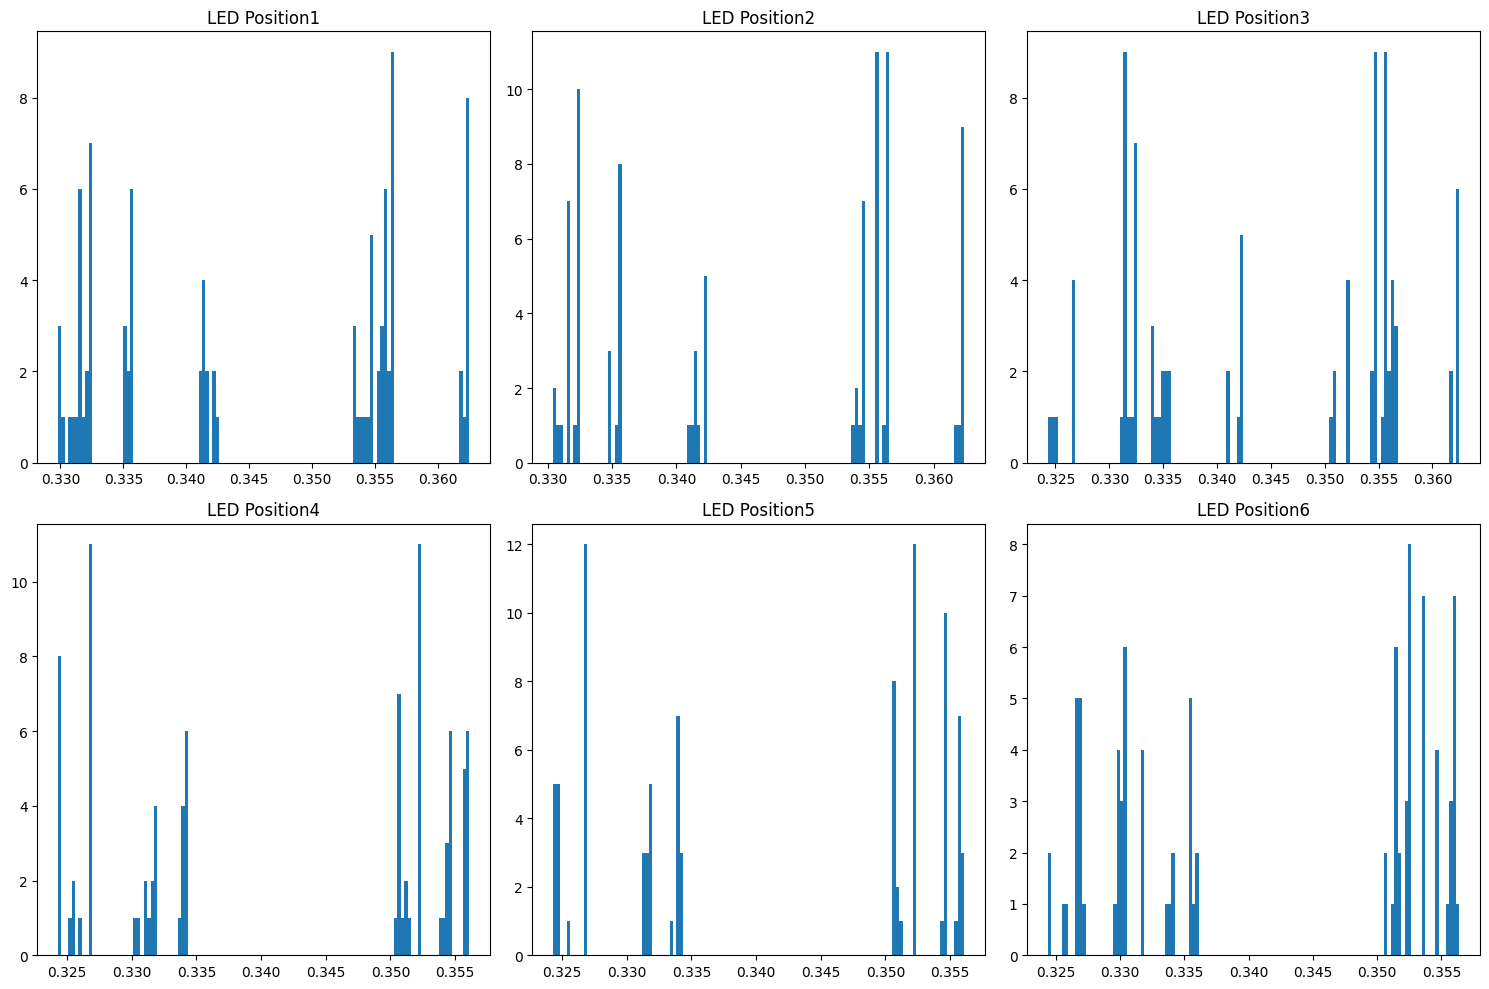

In [4]:
array = MEAS.values #Creates a ndarray with the values of the dataframe
positions = []
for i, position in enumerate(range(leds_per_nest*2)):
    position = array[i::leds_per_nest*2].reshape(-1, 1)
    positions.append(position)
values_per_position = result_array = np.concatenate(positions, axis=1).reshape(leds_per_nest*2, -1)
fig, axes = plt.subplots(int(leds_per_nest*2/3), 3, figsize=(15, 10)) #subplots
for i in range(6): #Subplots definitions
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.hist(values_per_position[i, :], 120)
    ax.set_title(f'LED Position{i+1}')
plt.tight_layout()
plt.show()

Filtering

![title](../media/Z-score.jpg)

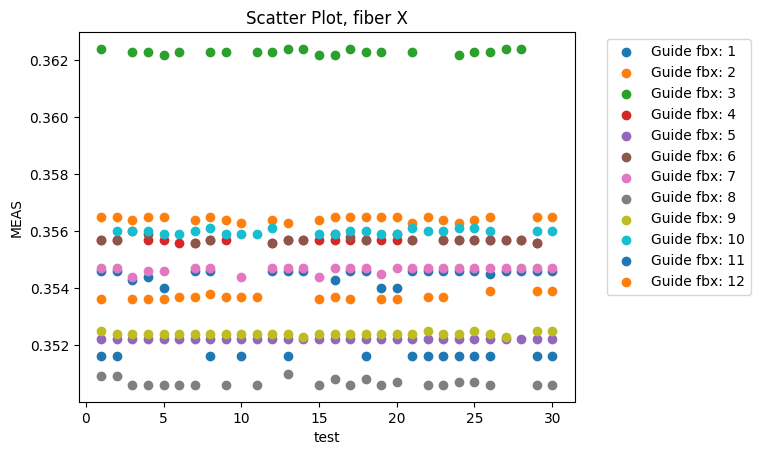

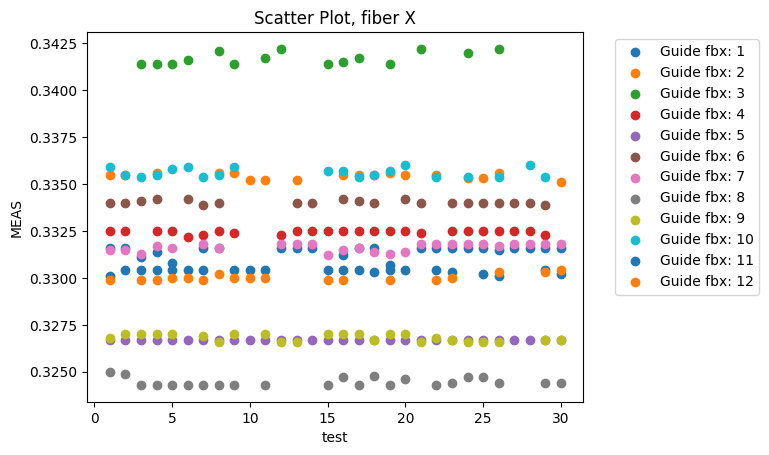

In [5]:
#Filter values by their row z-score
z_df = z_score_filter(df_plus_limits, 1)
#Plot the filtered values
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber X', 'test', 'MEAS', 'Guide fbx: ', filter='x')
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber X', 'test', 'MEAS', 'Guide fbx: ', filter='y')

In [6]:
#Split the dataframe for x fiber and y fiber
x_fiber = z_df[z_df.index % 2 == 0]
y_fiber = z_df[z_df.index % 2 != 0]
#Calculate the new RyR
RyRx, RyRy = RyR(z_df)

RyR Guide fbx 1: 4.119870548128411 % Status: Correct
RyR Guide fbx 2: 1.527525231651777 % Status: Correct
RyR Guide fbx 3: 1.3675269175155058 % Status: Correct
RyR Guide fbx 4: 0.7483314773547065 % Status: Correct
RyR Guide fbx 5: 1.1292025708167394e-12 % Status: Correct
RyR Guide fbx 6: 2.1291625896892716 % Status: Correct
RyR Guide fbx 7: 2.0282899481979317 % Status: Correct
RyR Guide fbx 8: 2.428421957070006 % Status: Correct
RyR Guide fbx 9: 0.9775812112711298 % Status: Correct
RyR Guide fbx 10: 1.4922019523734893 % Status: Correct
RyR Guide fbx 11: 1.1521328816827464e-12 % Status: Correct
RyR Guide fbx 12: 2.1001253095442887 % Status: Correct

RyR Guide fby 1: 5.207992742487084 % Status: Correct
RyR Guide fby 2: 3.360672201667362 % Status: Correct
RyR Guide fby 3: 6.738658902892062 % Status: Correct
RyR Guide fby 4: 1.739731780093573 % Status: Correct
RyR Guide fby 5: 2.2584051416334788e-12 % Status: Correct
RyR Guide fby 6: 1.8413245749937905 % Status: Correct
RyR Guide fby 7: 3.

In [7]:
df_plus_limits

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,LO_LIMIT,HI_LIMIT
0,0.3316,0.3316,0.3311,0.3314,0.3308,0.3298,0.3316,0.3316,0.3302,0.3298,...,0.3316,0.3316,0.3316,0.3315,0.3316,0.3316,0.3316,0.3316,0.3162,0.3462
1,0.3546,0.3546,0.3543,0.3544,0.3540,0.3534,0.3546,0.3546,0.3536,0.3534,...,0.3546,0.3546,0.3546,0.3545,0.3546,0.3546,0.3546,0.3546,0.3393,0.3693
2,0.3355,0.3355,0.3357,0.3356,0.3357,0.3350,0.3357,0.3356,0.3356,0.3352,...,0.3357,0.3353,0.3353,0.3356,0.3346,0.3349,0.3357,0.3351,0.3204,0.3504
3,0.3565,0.3565,0.3564,0.3565,0.3565,0.3562,0.3564,0.3565,0.3564,0.3563,...,0.3564,0.3563,0.3564,0.3565,0.3562,0.3562,0.3565,0.3565,0.3414,0.3714
4,0.3423,0.3424,0.3414,0.3414,0.3414,0.3416,0.3412,0.3421,0.3414,0.3412,...,0.3423,0.3420,0.3423,0.3422,0.3423,0.3423,0.3411,0.3411,0.3268,0.3568
5,0.3624,0.3625,0.3623,0.3623,0.3622,0.3623,0.3619,0.3623,0.3623,0.3619,...,0.3625,0.3622,0.3623,0.3623,0.3624,0.3624,0.3618,0.3618,0.3472,0.3772
6,0.3325,0.3325,0.3321,0.3325,0.3325,0.3322,0.3323,0.3325,0.3324,0.3318,...,0.3325,0.3325,0.3325,0.3325,0.3325,0.3325,0.3323,0.3320,0.3174,0.3474
7,0.3557,0.3557,0.3555,0.3557,0.3557,0.3556,0.3556,0.3557,0.3557,0.3554,...,0.3557,0.3557,0.3557,0.3557,0.3557,0.3557,0.3556,0.3554,0.3406,0.3706
8,0.3267,0.3267,0.3267,0.3267,0.3267,0.3267,0.3267,0.3267,0.3267,0.3267,...,0.3267,0.3267,0.3267,0.3267,0.3267,0.3267,0.3267,0.3267,0.3117,0.3417
9,0.3522,0.3522,0.3522,0.3522,0.3522,0.3522,0.3522,0.3522,0.3522,0.3522,...,0.3522,0.3522,0.3522,0.3522,0.3522,0.3522,0.3522,0.3522,0.3372,0.3672


In [8]:
print(len(positions))
print(len(positions[0]))

8
90
